In [130]:
%matplotlib inline
# Importations 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import scipy
import matplotlib.pylab as pl
import ot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
# necessary for 3d plot even if not used
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.collections import PolyCollection  # noqa

data=pd.read_csv('adultTrainTest.csv')
data.head()

age          workClass  fnlwgt   education  educNum             mariStat  \
0   39          State-gov   77516   Bachelors       13        Never-married   
1   50   Self-emp-not-inc   83311   Bachelors       13   Married-civ-spouse   
2   38            Private  215646     HS-grad        9             Divorced   
3   53            Private  234721        11th        7   Married-civ-spouse   
4   28            Private  338409   Bachelors       13   Married-civ-spouse   

                occup    relationship origEthn      sex  capitalGain  \
0        Adm-clerical   Not-in-family    White     Male         2174   
1     Exec-managerial         Husband    White     Male            0   
2   Handlers-cleaners   Not-in-family    White     Male            0   
3   Handlers-cleaners         Husband    Black     Male            0   
4      Prof-specialty            Wife    Black   Female            0   

   capitalLoss  hoursWeek    nativCountry  income  
0            0         40   United-States   <=50K  
1            0         13   United-States   <=50K  
2            0         40   United-States   <=50K  
3            0         40   United-States   <=50K  
4            0         40            Cuba   <=50K

In [131]:
num_features = ['age', 'educNum', 'capitalGain', 'capitalLoss', 'hoursWeek','sex','income']
data = data[num_features]

label_encoder = preprocessing.LabelEncoder()  
data['sex']= label_encoder.fit_transform(data['sex'])                    # Encode labels in column 'species'
data['income']= label_encoder.fit_transform(data['income'])

In [132]:
data.corrwith(data['income'])

age            0.230369
educNum        0.332613
capitalGain    0.223013
capitalLoss    0.147554
hoursWeek      0.227687
sex            0.214628
income         1.000000
dtype: float64

In [133]:
def disparate_impact_scorer(y, y_pred, X):

  indexes = y.index.tolist()
  X = X.loc[:]
  y = y.tolist()
  y_pred = y_pred.tolist()
  
  X['y_pred'] = y_pred
 

  p1 = len(X[(X['y_pred']==1) & (X["sex"] == 0)]) / len(X)
  p2 = len(X[(X["sex"] == 0)]) / len(X)
  p3 = len(X[(X['y_pred']==1) & (X["sex"] == 1)]) / len(X)
  p4 = len(X[(X["sex"] == 1)]) / len(X)

  return min(((p1/p2)/(p3/p4)), ((p3/p4)/(p1/p2)))

In [134]:
def BER_scorer(y, y_pred):

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  return (0.5 * ((fn/(fn + tp))+(fp/(fp + tn))))

In [135]:
######this function would return n0 number of female samples and n1 number of male sample from the datset
def sample(n1,n0):
    X0 = data[(data['sex'] == 0)].sample(n0)
    X1 = data[(data['sex'] == 1)].sample(n1)

    # apply normalization techniques
    for column in X0.columns:
        X0[column] = (X0[column] - X0[column].min()) / (X0[column].max() - X0[column].min())
    for column in X1.columns:
        X1[column] = (X1[column] - X1[column].min()) / (X1[column].max() - X1[column].min()) 

    X0['sex'] = 0
    X1['sex'] = 1
    
    return X1,X0
    

In [136]:
######training and testing the data set with original data using random forest classifier

X1,X0 = sample(3000,1500)
X = pd.concat([X0,X1])
train_set, test_set = train_test_split(X, test_size=0.3, random_state=42, stratify=X['sex'])

x_train = train_set.drop('income', axis=1)
x_test = test_set.drop('income', axis=1)

y_train = train_set['income']
y_test = test_set['income']


rfc = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

print(f"Test set accuracy = {accuracy_score(y_test, y_pred)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"True pos {tp}")
print(f"False pos {fp}")
print(f"True neg {tn}")
print(f"False neg {fn}")
print(f"Area under ROC curve {roc_auc_score(y_test, y_pred)}")
print(f"Balanced Error Rate: {BER_scorer(y_test, y_pred)}")

Test set accuracy = 0.7925925925925926
True pos 173
False pos 128
True neg 897
False neg 152
Area under ROC curve 0.7037148217636022
Balanced Error Rate: 0.2962851782363978


In [137]:
print(f"Disparate Impact: {disparate_impact_scorer(y_test, y_pred, x_test)}")

Disparate Impact: 0.32432432432432434


In [138]:
######training and testing the data set with original data using LogisticRegression classifier using above dataset

cls = linear_model.LogisticRegression()
cls.fit(x_train, y_train)

y_pred = cls.predict(x_test)
print(f"LogisticRegression : Accuracy:{accuracy_score(y_test, y_pred)}, Disparate Impact:{disparate_impact_scorer(y_test, y_pred, x_test)}")
print(f"Balanced Error Rate: {BER_scorer(y_test, y_pred)}")

LogisticRegression : Accuracy:0.8244444444444444, Disparate Impact:0.05847953216374268
Balanced Error Rate: 0.31838649155722326


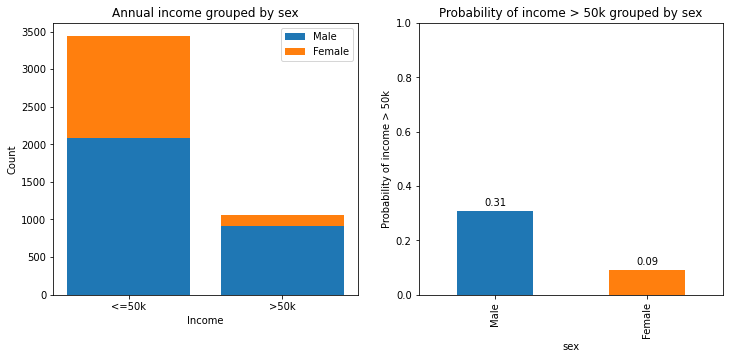

In [139]:
#####Statistical parity plot

female_income = X[X['sex'] == 0]['income'] # female == 0        <=50k == 0
male_income = X[X['sex'] == 1]['income'] # male == 1            >=50k == 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5)) # [1 x 2] grid
ax1.bar(['<=50k', '>50k'], male_income.value_counts(), label='Male')
ax1.bar(['<=50k', '>50k'], female_income.value_counts(), bottom=male_income.value_counts(), label='Female')
ax1.set_xlabel('Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual income grouped by sex')
ax1.legend()
ax2_y = X.groupby('sex')['income'].mean().sort_values(ascending=False)
ax2_y.plot.bar(x=['Male', 'Female'], color=['#1f77b4', '#ff7f0e'], ylim=[0, 1])
ax2.set_ylabel('Probability of income > 50k')
ax2.set_title('Probability of income > 50k grouped by sex')
ax2.set_xticklabels(['Male', 'Female'])
for i, v in enumerate(ax2_y):
    ax2.text(i-0.07, v+0.02, '{:.2f}'.format(v))
plt.show()

In [140]:
#### this function returns the repaired data set taking input as x0: female sample, x1: male sample, lamda: amount of repair
def repair_data(X0,X1,lamda):
    x0 = X0.drop(["sex","income"],axis = 1)
    x1 = X1.drop(["sex","income"],axis = 1)
    
    arr  = x0.to_numpy()
    arr1 = x1.to_numpy()

    cost_matrix = ot.dist(arr, arr1)
    cost_matrix/=cost_matrix.max()                                           #####calculating cost matrix
    
    a = np.full(len(arr),1/len(arr))
    b = np.full(len(arr1),1/len(arr1))

    ot_map = ot.emd(a,b,cost_matrix)
    
    repair_x0 = pd.DataFrame()
    repair_x1 = X1
    for i in range(len(arr)):
        for j in range(1,len(arr1)):
            ot_map[i][j]+= ot_map[i][j-1]

    for i in range(len(arr)):
        if random.uniform(0,1)<lamda:
            k = random.uniform(0,1/len(arr1))
            for j in range (len(arr1)):
                if ot_map[i][j]>k:
                    repair_x0 = repair_x0.append(X1.iloc[j,:],ignore_index=True)       ########replacing the female reocrd with relevant male record
                    break
        else:
            repair_x0 = repair_x0.append(X0.iloc[i,:],ignore_index=True)  

    repair_x0['sex'] = 0

    return pd.concat([repair_x0,repair_x1])         ####this is repaired dataset

In [141]:
##### again training and testing using the repaired dataset

repaired_data = repair_data(X[(X['sex'] == 0)],X[(X['sex'] == 1)],0.8)
repair_train = repair_data(train_set[(train_set['sex'] == 0)],train_set[(train_set['sex'] == 1)],0.8)
repair_test  = repair_data(test_set[(test_set['sex'] == 0)],test_set[(test_set['sex'] == 1)],0.8)


x_train = repair_train.drop('income', axis=1)
x_test = repair_test.drop('income', axis=1)

y_train = repair_train['income']
y_test = repair_test['income']

######Random forest classifier
rfc = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
print(f"Random forest: Accuracy:{accuracy_score(y_test, y_pred)}, Disparate Impact:{disparate_impact_scorer(y_test, y_pred, x_test)}")
print(f"Balanced Error Rate: {BER_scorer(y_test, y_pred)}")
######LogisticRegression 
cls = linear_model.LogisticRegression()
cls.fit(x_train, y_train)

y_pred = cls.predict(x_test)
print(f"LogisticRegression : Accuracy:{accuracy_score(y_test, y_pred)}, Disparate Impact:{disparate_impact_scorer(y_test, y_pred, x_test)}")
print(f"Balanced Error Rate: {BER_scorer(y_test, y_pred)}")

Random forest: Accuracy:0.7592592592592593, Disparate Impact:0.9156626506024097
Balanced Error Rate: 0.29969761997658995
LogisticRegression : Accuracy:0.7851851851851852, Disparate Impact:0.813953488372093
Balanced Error Rate: 0.30928753311292273


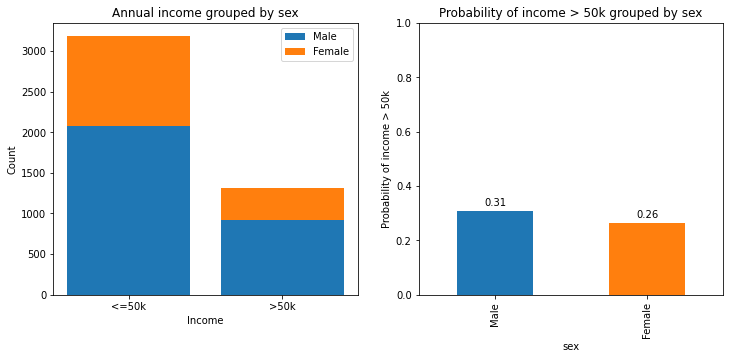

In [142]:
#######Statistical parity using repaired datset

female_income = repaired_data[repaired_data['sex'] == 0]['income'] # female == 0        <=50k == 0
male_income = repaired_data[repaired_data['sex'] == 1]['income'] # male == 1            >=50k == 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5)) # [1 x 2] grid
ax1.bar(['<=50k', '>50k'], male_income.value_counts(), label='Male')
ax1.bar(['<=50k', '>50k'], female_income.value_counts(), bottom=male_income.value_counts(), label='Female')
ax1.set_xlabel('Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual income grouped by sex')
ax1.legend()
ax2_y = repaired_data.groupby('sex')['income'].mean().sort_values(ascending=False)
ax2_y.plot.bar(x=['Male', 'Female'], color=['#1f77b4', '#ff7f0e'], ylim=[0, 1])
ax2.set_ylabel('Probability of income > 50k')
ax2.set_title('Probability of income > 50k grouped by sex')
ax2.set_xticklabels(['Male', 'Female'])
for i, v in enumerate(ax2_y):
    ax2.text(i-0.07, v+0.02, '{:.2f}'.format(v))
plt.show()

In [143]:
lamda = 0
acc = []
di  = []
lam = np.arange(0, 1,0.1)
for lamda in lam:
    
    repair_train = repair_data(train_set[(train_set['sex'] == 0)],train_set[(train_set['sex'] == 1)],lamda)
    repair_test  = repair_data(test_set[(test_set['sex'] == 0)],test_set[(test_set['sex'] == 1)],lamda)


    x_train = repair_train.drop('income', axis=1)
    x_test = repair_test.drop('income', axis=1)

    y_train = repair_train['income']
    y_test = repair_test['income']


    rfc = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
    rfc.fit(x_train, y_train)

    y_pred = rfc.predict(x_test)

    acc.append(accuracy_score(y_test, y_pred))
    di.append(disparate_impact_scorer(y_test, y_pred, x_test))    
    
    lamda+=0.1

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

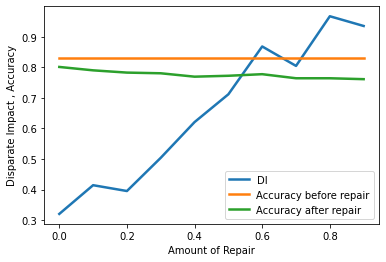

In [144]:
######plot showing amount of repair vs disparate impact and accuracy(before and after the repair)
plt.plot(lam,di,linewidth = 2.5, label='DI')
plt.plot(lam,np.full(10,0.83),linewidth = 2.5,label='Accuracy before repair')
plt.plot(lam,acc,linewidth = 2.5, label='Accuracy after repair')
plt.xlabel('Amount of Repair')
plt.ylabel('Disparate Impact , Accuracy')
plt.rcParams["figure.figsize"] = (8,5.5)
plt.legend()
plt.plot